In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'credit-card-approval-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F426827%2F1031720%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241007%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241007T163748Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D065aa75fbca4ff87c9dd3d82d172a5d76b815a937e7bed204966b2c4f462b7b06bb718ae3a1ca80b98eb33b509233804bacebdfd4823b71dc8000c22cada8cd6cf0beb98e1075336a06255cf82b925cf5543261b613b4bd0f2a2ebc746926d8698b82467773ae6a37453aab74127ba4db97d1e2cca09f82978d9e39de814eb95dda22929b98f0273dcb5d8211b1c2d6ab2e2c54ab488ea49a6d98f2bbc0ad1462a6b4d57685b59d76da9d21f0d3ea1d214311038c2e984ad6e157754b272e3482114431d8cb2426a7d4c2de369cf2ea77b81ededb602d521e50bfafddb016f1bb47747dfaf32ac694b5cb8bba4e75b9bd337695f7947058e40a07669599f7aed'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5578875 bytes downloaded
Downloaded and uncompressed: credit-card-approval-prediction
Data source import complete.


  <h1 style="color: gray; font-weight: bold;">Credit Card Approval Prediction</h1>




# **Problem Statement**

Credit score cards are used in the financial industry to predict the likelihood of credit card defaults and guide the issuance of credit cards. These scores rely on applicants' personal data and historical information, quantifying risk objectively.

**This project wants to create Random Forest Classifier Model to help banks decide who should get a credit card.**

# **Loading Libraries**

In [ ]:
# loading libraries

# general libraries
import pandas as pd
import numpy as np

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# stats libraries
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report, f1_score, precision_score, recall_score

# **Column Description of Application Record Dataset:**

| Feature Name        | Explanation                  | Remarks                                                  |
|---------------------|------------------------------|----------------------------------------------------------|
| ID                  | Client number                |                                                          |
| CODE_GENDER         | Gender                       |                                                          |
| FLAG_OWN_CAR        | Is there a car               |                                                          |
| FLAG_OWN_REALTY     | Is there a property          |                                                          |
| CNT_CHILDREN        | Number of children           |                                                          |
| AMT_INCOME_TOTAL    | Annual income                |                                                          |
| NAME_INCOME_TYPE    | Income category              |                                                          |
| NAME_EDUCATION_TYPE | Education level              |                                                          |
| NAME_FAMILY_STATUS  | Marital status               |                                                          |
| NAME_HOUSING_TYPE   | Way of living (House Type)                |                                                          |
| DAYS_BIRTH          | Birthday                     | Count backwards from current day (0), -1 means yesterday |
| DAYS_EMPLOYED       | Start date of employment     | Count backwards from current day(0). If positive, it means the person currently unemployed. |
| FLAG_MOBIL          | Is there a mobile phone      |                                                          |
| FLAG_WORK_PHONE     | Is there a work phone        |                                                          |
| FLAG_PHONE          | Is there a phone             |                                                          |
| FLAG_EMAIL          | Is there an email            |                                                          |
| OCCUPATION_TYPE     | Occupation                   |                                                          |
| CNT_FAM_MEMBERS     | Family size                  |                                                          |


# **Loading Dataset(Application Record)**

In [ ]:
# loading the datatset containing application record

df_application_record = pd.read_csv('/kaggle/input/credit-card-approval-prediction/application_record.csv')

# previewing the dataset

df_application_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


# **Getting know about the dataset(Application Record)**

In [ ]:
# checking shape of the dataset (application_record)

print('The number of rows in Application Record dataset is', df_application_record.shape[0] , '\n')

print('The number of columns in Application Record dataset is', df_application_record.shape[1])

The number of rows in Application Record dataset is 438557 

The number of columns in Application Record dataset is 18


In [ ]:
df_application_record.dtypes # checking datatypes

,0
ID,int64
CODE_GENDER,object
FLAG_OWN_CAR,object
FLAG_OWN_REALTY,object
CNT_CHILDREN,int64
AMT_INCOME_TOTAL,float64
NAME_INCOME_TYPE,object
NAME_EDUCATION_TYPE,object
NAME_FAMILY_STATUS,object
NAME_HOUSING_TYPE,object


----
### **Observation**
- The dataset of application record contains 438557 rows and 18 columns
- This dataset contains eight of columns of `object` datatype
- And remaining 10 columns has of `numric` datatype
----

# **Column Decription of Credit Record Dataset**

| Feature Name    | Explanation     | Remarks                                                                                       |
|-----------------|-----------------|-----------------------------------------------------------------------------------------------|
| ID              | Client number   |                                                                                               |
| MONTHS_BALANCE  | Record month    | The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on |
| STATUS          | Status          | 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month |


# **Loading Dataset(Credit Record)**

In [ ]:
# loading the datatset containing credit record

df_credit_record = pd.read_csv('/kaggle/input/credit-card-approval-prediction/credit_record.csv')

# previewing the dataset

df_credit_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


# **Getting know about the dataset(Credit Record)**

In [ ]:
# checking shape of the dataset (credit_record)

print('The number of rows in Credit Record dataset is', df_credit_record.shape[0] , '\n')

print('The number of columns in Credit Record dataset is', df_credit_record.shape[1])

The number of rows in Credit Record dataset is 1048575 

The number of columns in Credit Record dataset is 3


In [ ]:
# checking data types

df_credit_record.dtypes

,0
ID,int64
MONTHS_BALANCE,int64
STATUS,object


---

### **Observation**

- The dataset of credit record contains 1048575 rows and 3 columns
- This dataset contains 1 columns of `object` datatype which shows `Status` of billing details status of creddit card
- And remaining 2 columns has  `numric` datatype

----

# **Merging two datasets (Basis of common `ID`)**

In [ ]:
# Merging the two datasets on ID basis

df = pd.merge(df_application_record, df_credit_record, on='ID' , how='inner')

---
- We merge two dataframes on basis of `ID` column present in both datasets.
- Moreover, `Credit record` dataset has more records of clients than `Application record` dataset, so we make sure that our new datafrmae `df` contains only those rows which have the same `ID` number
- For that purose we use `inner` parameter in `pd.merge` function
----

# **Previewing the merged dataset**

In [ ]:
# previewing the dataset

df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


# **Getting know about the merged dataset**

In [ ]:
# checking the shape of the new dataframe

print(f'The number of rows in merged dataset (df) = {df.shape[0]} \n The number of columns in merged dataset (df) is = {df.shape[1]}' )

The number of rows in merged dataset (df) = 777715 
 The number of columns in merged dataset (df) is = 20


----
### **Observation:**

- At earlier we have seen that `Application record` dataset has `438557` rows
- Now, our merged dataset has only contain `777715`
- That means `Application Record & Credit Record` dataset has only `777715` rows which have common `ID` numbers

----

# **Checking for missing values & Dealing with them**

In [ ]:
# checking for null values

df.isna().sum()

,0
ID,0
CODE_GENDER,0
FLAG_OWN_CAR,0
FLAG_OWN_REALTY,0
CNT_CHILDREN,0
AMT_INCOME_TOTAL,0
NAME_INCOME_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_FAMILY_STATUS,0
NAME_HOUSING_TYPE,0


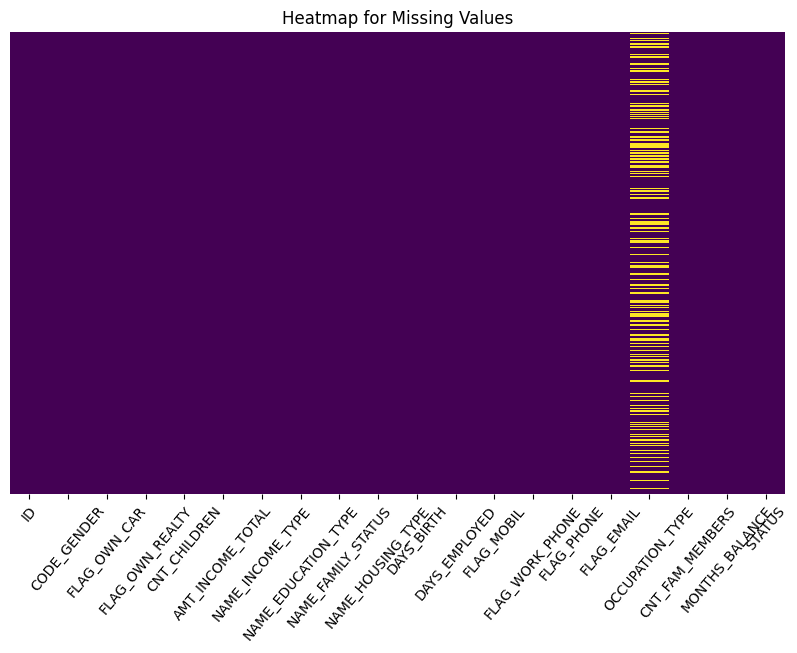

In [ ]:
# plotting the heatmap to check for null values

# definig the figure size
plt.figure(figsize=(10, 6))

# plotting the heatmap of missing values
sns.heatmap(df.isna(), cbar=False , yticklabels=False, cmap='viridis')

# defining the title
plt.title('Heatmap for Missing Values')
plt.xticks(rotation=50)
plt.show()

In [ ]:
# check for the percentage of missing values in `OCCUPATION_TYPE` column

df['OCCUPATION_TYPE'].isna().sum() / df.shape[0] * 100

30.86580559716606

---
### **Observation:**

- There are only one column in our datafrme which has null values.
- This column is `OCCUPATION_TYPE` and it has `240048` missing values and it has percentage of `30.86%` missing values

- We have only one option which is to drop the column `OCCUPATION_TYPE` because it has a high percentage of missing values and secondly every person has itd own unique record. and we cannot simply impute the missing values with mode

----



In [ ]:
df.drop('OCCUPATION_TYPE', axis=1, inplace=True) # dropping the column `OCCUPATION_TYPE`

In [ ]:
# confirming the outcome

df.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS'],
      dtype='object')

# **Checking for unique values count in dataframe**

In [ ]:
# check for the count of unique values in each column

df.nunique()

,0
ID,36457
CODE_GENDER,2
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
CNT_CHILDREN,9
AMT_INCOME_TOTAL,265
NAME_INCOME_TYPE,5
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,5
NAME_HOUSING_TYPE,6


---

### **Observation:**
- Our dataset has `777715` rows but there are only `36457` unique values in `ID` column.
- This shows that there maybe duplicates in our dataset
---

# **Checking for duplicates**

In [ ]:
# checking for duplicates

df.duplicated().sum()

0

In [ ]:
df[df['ID'].duplicated()].head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-4,C
5,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-5,C
6,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-6,C
7,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-7,C
8,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-8,C
9,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-9,C
10,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0,-10,C


---

In [ ]:
df[df['ID'].duplicated()].tail(20)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
777694,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-3,0
777695,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-4,0
777696,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-5,0
777697,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-6,0
777698,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-7,0
777699,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-8,0
777700,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,-17958,-655,1,0,0,0,2.0,-9,0
777702,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,1.0,-1,0
777703,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,1.0,-2,0
777704,5150337,M,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,Rented apartment,-9188,-1193,1,0,0,0,1.0,-3,0


---

### **Observation:**

- By carefully checking the dataset we can say that on basis of number of unique enteries in `ID` column we have data of `36457` clients.
- And there are no duplicates in our dataset the data of `36457 ID` which is collected on the basis of different months of `MONTHS_BALANCE`
---

# **Renaming the columns**

In [ ]:
df.columns # checking the columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'MONTHS_BALANCE', 'STATUS'],
      dtype='object')

In [ ]:
# renaming columns in a meaning full way

df.rename(columns={
    'CODE_GENDER': 'gender',
    'FLAG_OWN_CAR': 'own_car',
    'FLAG_OWN_REALTY': 'own_property',
    'CNT_CHILDREN': 'children',
    'AMT_INCOME_TOTAL': 'income',
    'NAME_INCOME_TYPE': 'income_type',
    'NAME_EDUCATION_TYPE': 'education',
    'NAME_FAMILY_STATUS': 'family_status',
    'NAME_HOUSING_TYPE': 'housing_type',
    'FLAG_MOBIL': 'mobile',
    'FLAG_WORK_PHONE': 'work_phone',
    'FLAG_PHONE': 'phone',
    'FLAG_EMAIL': 'email',
    'CNT_FAM_MEMBERS': 'family_members',
    'MONTHS_BALANCE': 'months_balance',
    'STATUS' : 'status',
    'DAYS_BIRTH' : 'age_in_days',
    'DAYS_EMPLOYED' : 'employment_in_days'

} , inplace=True)


In [ ]:
df.columns

Index(['ID', 'gender', 'own_car', 'own_property', 'children', 'income',
       'income_type', 'education', 'family_status', 'housing_type',
       'age_in_days', 'employment_in_days', 'mobile', 'work_phone', 'phone',
       'email', 'family_members', 'months_balance', 'status'],
      dtype='object')

# **Mapping the values in a meaningful way**

In [ ]:
# checking for columns with object dtype

df.select_dtypes(include='object').columns

Index(['gender', 'own_car', 'own_property', 'income_type', 'education',
       'family_status', 'housing_type', 'status'],
      dtype='object')

In [ ]:
# checking for unique values in some columns

col = ['gender', 'own_car', 'own_property']

for i in col:
    print(f'{df[i].value_counts()}')



gender
F    518851
M    258864
Name: count, dtype: int64
own_car
N    473355
Y    304360
Name: count, dtype: int64
own_property
Y    512948
N    264767
Name: count, dtype: int64


In [ ]:
# maping the values in some columns


# mapping unique enteries of gender
df['gender'] = df['gender'].map({'F':'female', 'M': 'male'})

# mapping unique enteries of own_car
df['own_car'] = df['own_car'].map({'N': 'no', 'Y': 'yes'})

# mapping unique enteries of own_property
df['own_property'] = df['own_property'].map({'N': 'no', 'Y': 'yes'})

In [ ]:
# check for unique values in status column

df['status'].value_counts()

,count
status,
C,329536
0,290654
X,145950
1,8747
5,1527
2,801
3,286
4,214


# **Feature Engineering**

In [ ]:
# maping the values in status column and storing result in new column

df['loan_status'] = df['status'].map({'0': 'first_month_due' , '1': '2nd_month_due', '2' : '3rd_month_overdue',  '3': '4th_month_overdue',
                                '4' : '5th_month_overdue', '5' : 'bad_debt' , 'C': 'good' , 'X' : 'no_loan'})


In [ ]:
# confirming the outcome

df.columns.values

array(['ID', 'gender', 'own_car', 'own_property', 'children', 'income',
       'income_type', 'education', 'family_status', 'housing_type',
       'age_in_days', 'employment_in_days', 'mobile', 'work_phone',
       'phone', 'email', 'family_members', 'months_balance', 'status',
       'loan_status'], dtype=object)

# **Exploratory Data Analysis**

---
### **Purpose:**
- The main goal of the analysis is to get ideas about the different attributes of the clients.
- To get an overview of the distribution of the data.
- To get an overview of the relationship between the attributes.
- Particularly, to get an overview of the relationship between the attributes and the target variable[`loan_status`].
---

### **Checking for distribution of `[gender , own_car,  own_property , income_type]`**

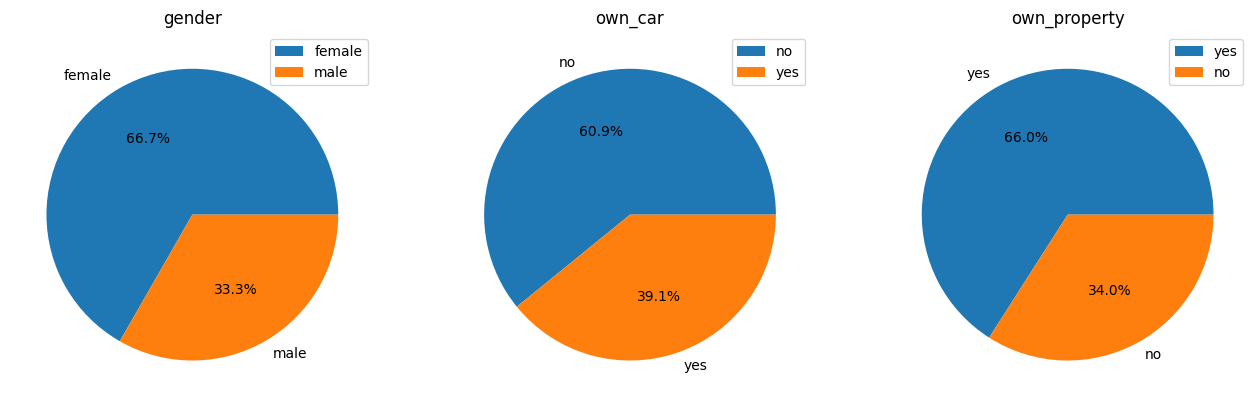

In [ ]:

# Define the list of column names
columns = ['gender', 'own_car', 'own_property']

# Create subplots for each column
plt.figure(figsize=(16 , 9))  # Adjust the figure size as needed

for i in range(len(columns)):
    plt.subplot(1, 3, i+1)
    plt.title(columns[i])  # Use the column name as the title

    # Plot pie chart
    counts = df[columns[i]].value_counts()
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%'  )

    # Add legend with unique values
    plt.legend(counts.index)
plt.show()


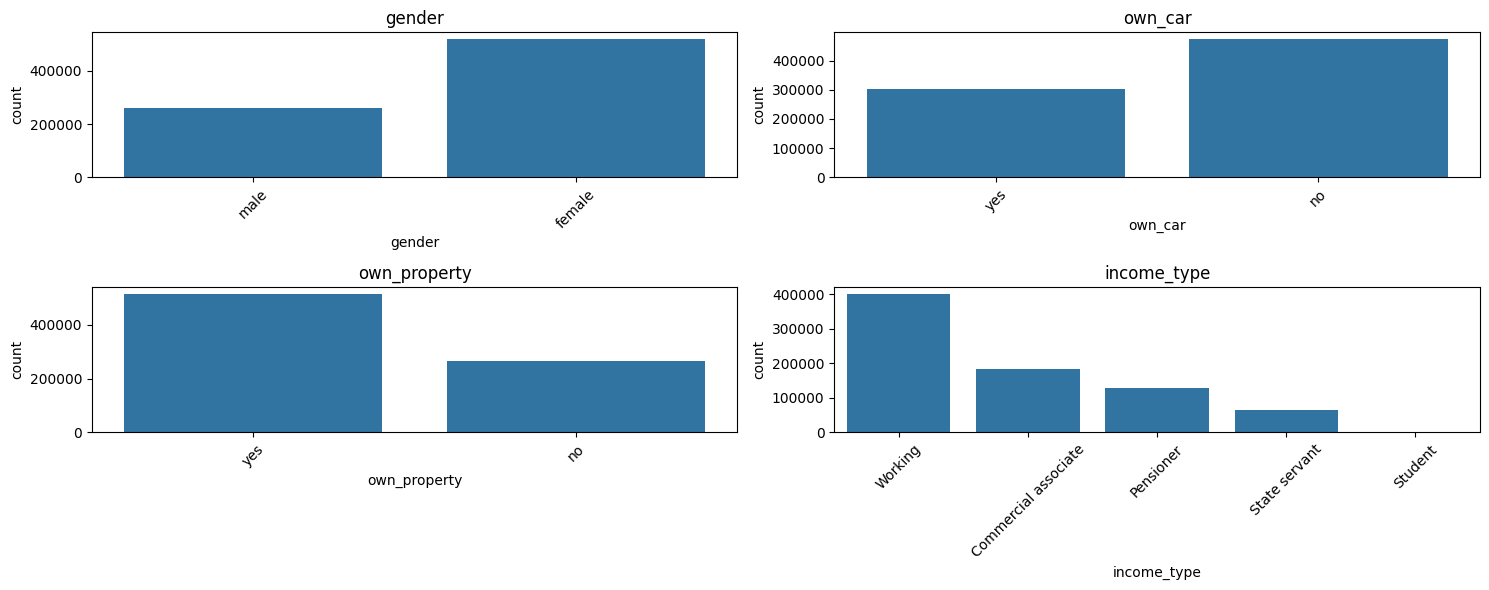

In [ ]:
# creating list of specific columns
col = ['gender', 'own_car', 'own_property', 'income_type',]

# defining the figure size
plt.figure(figsize=(15, 6))

# plotting the countplot using for loop
for i in range(len(col)):
    # defining the subplot
    plt.subplot(2, 2, i+1)
    # adding title
    plt.title(col[i])
    # plotting the countplot
    sns.countplot(data=df, x=df[col[i]])
    # rotating the x-axis labels
    plt.xticks(rotation=45)
# layout adjustment
plt.tight_layout()
plt.show()

----

### **Observation:**

- There are more Female clients in our dataframe than the male clients
- The number of clients who don't have car is more than the number of clients who have car
- More number of clients have their own property
---

In [ ]:
# checking the count of loan status

df['loan_status'].value_counts()

,count
loan_status,
good,329536
first_month_due,290654
no_loan,145950
2nd_month_due,8747
bad_debt,1527
3rd_month_overdue,801
4th_month_overdue,286
5th_month_overdue,214


---
### **Observation:**
- Most of the clients in our dataset have paid off their loan for that month
- first month loan due and no loan for the month comes at 2nd and 3rd place respectively in terms of value counts
- `1527` clients have bad debt

---

### **Getting insight from `loan status v/s gender`**

### *plotting count plot of loan status v/s gender*

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


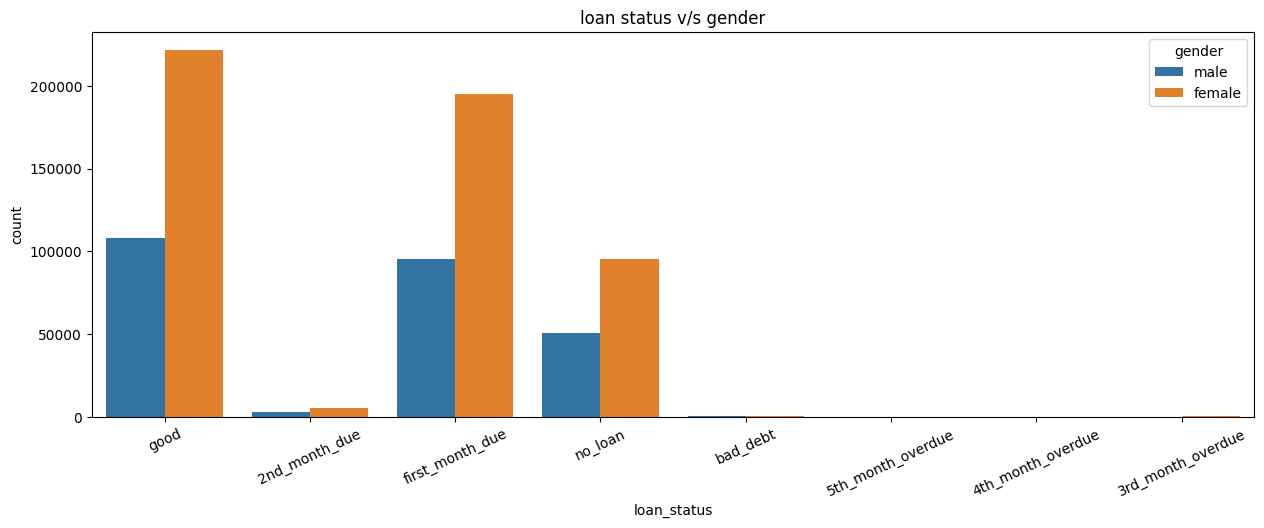

In [ ]:
# checking the relationship between loan status and gender

# defining the figure size
plt.figure(figsize=(15, 5))

# plotting the countplot
sns.countplot(data=df, x=df['loan_status'], hue=df['gender'])

# defining the tilte
plt.title('loan status v/s gender')
# rotating the x-axis labels
plt.xticks(rotation=25)
plt.show()

### *getting the value count of loan status v/s gender which are less than 10000*

In [ ]:
# value count of loan status v/s gender
filtered_loan = df.groupby('loan_status')['gender'].value_counts()

# filtering the values less than 10000
filtered_loan[filtered_loan<10000].unstack()

gender,female,male
loan_status,,
2nd_month_due,5530,3217
3rd_month_overdue,510,291
4th_month_overdue,178,108
5th_month_overdue,128,86
bad_debt,809,718


### *Bar Plot of the relationship between loan_status and gender which have values less than 10000*

<Figure size 1500x900 with 0 Axes>

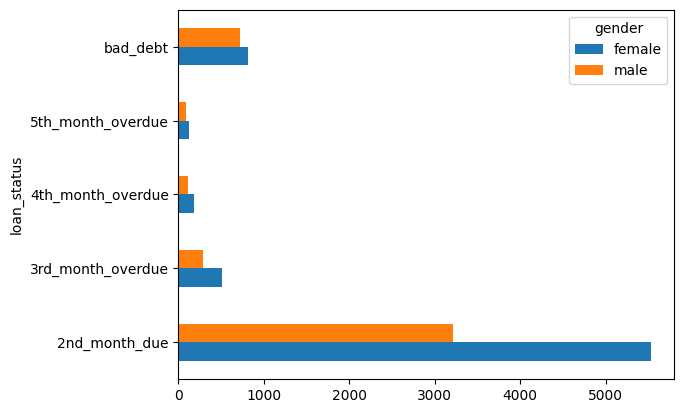

In [ ]:
# value count of loan status v/s gender
filtered_loan = df.groupby('loan_status')['gender'].value_counts()

# filtering the values less than 10000

plt.figure(figsize=(15, 9))

filtered_loan[filtered_loan<10000].unstack().plot(kind='barh')

plt.show()

---

### **Observation:**

- As our dataset has more number of females than males so the count of female is larger than the count of males who have paid off their loan for that month and have no loan for the month
- Moreover, the females have more  over due and bad debt than males
---

#### **Getting insight from `loan status v/s gender`**

In [ ]:
df.columns # getting the exact column names

Index(['ID', 'gender', 'own_car', 'own_property', 'children', 'income',
       'income_type', 'education', 'family_status', 'housing_type',
       'age_in_days', 'employment_in_days', 'mobile', 'work_phone', 'phone',
       'email', 'family_members', 'months_balance', 'status', 'loan_status'],
      dtype='object')

### *checking value count of` income_type`s*

In [ ]:
# checking the value count of income type

df['income_type'].value_counts()

,count
income_type,
Working,400164
Commercial associate,183385
Pensioner,128392
State servant,65437
Student,337


### *checking the relationship between `income type and gender`*

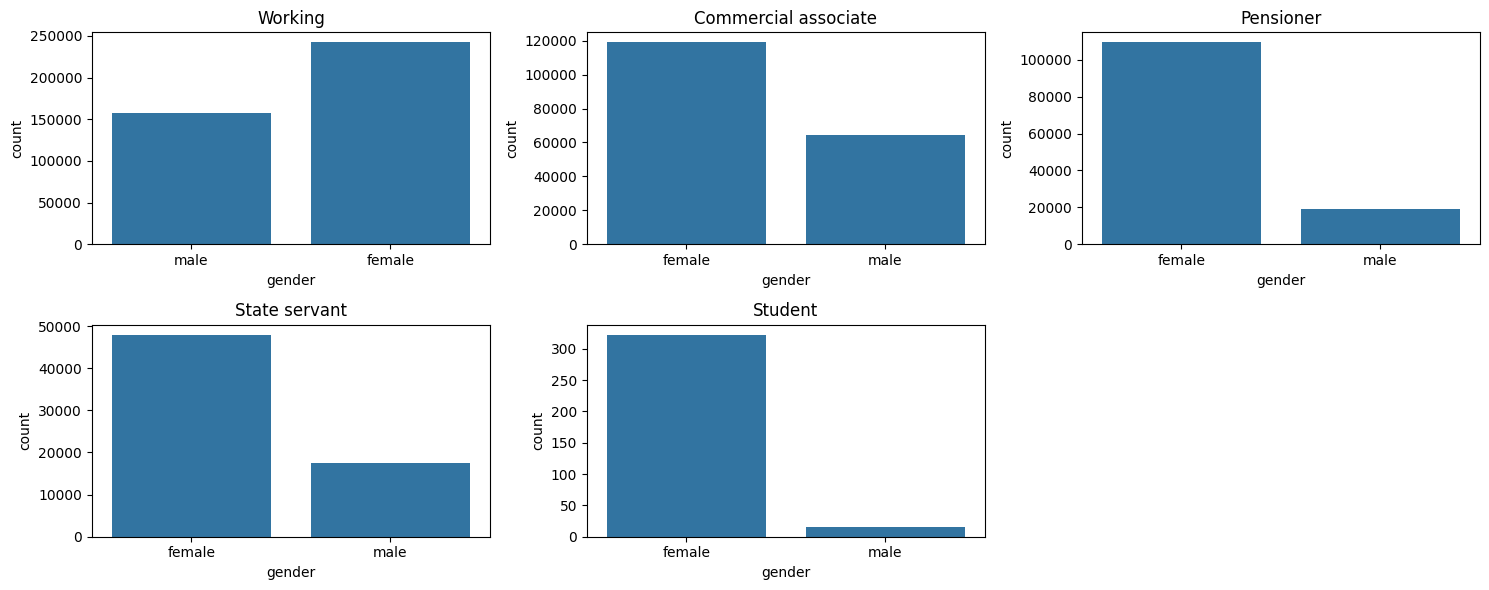

In [ ]:

count = df['income_type'].value_counts()

plt.figure(figsize=(15, 6))

# Plotting the countplot for each unique value of 'income_type'
for i in range(len(count)):
    plt.subplot(2, 3, i+1)
    plt.title(count.index[i])  # Use the unique value of 'income_type' as the title
    sns.countplot(data=df[df['income_type'] == count.index[i]], x='gender')

plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()


---
### **Observation**
- In `Working and Commercial assciate income_type` the number of male clients is half of the female clients
- Whereas, in `income_type = Pensioner and  Students` males ATM clients numbers are very less as compared to females
---

### **Checking the relationship between `loan status and income type`**

### *plotting the bar plot of unique values of `loan_status` v/s `income_type`*

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

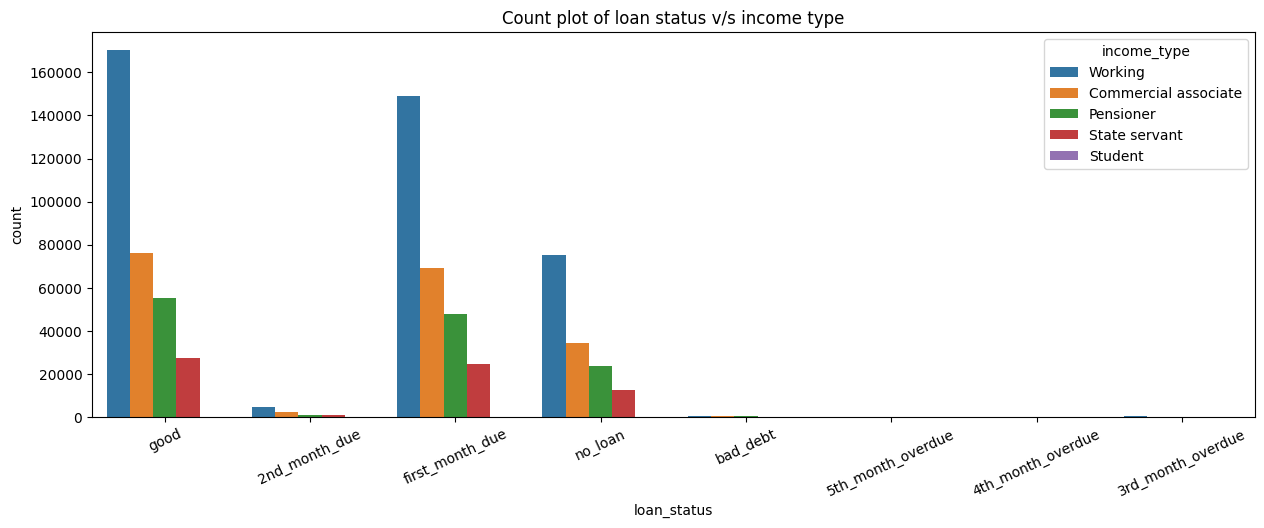

In [ ]:
# checking the relationship between loan status and income type

# defining the figure size
plt.figure(figsize=(15, 5))

# plotting the countplot
sns.countplot(data=df, x=df['loan_status'], hue=df['income_type'])

# defining the tilte
plt.title('Count plot of loan status v/s income type')
plt.xticks(rotation=25)
plt.show()


----

### **Observation:**

- Most of the clients with `working income_type` have paid off their loan for that month
- Similar trend can be seen in the income catagories like `first_month_due & no_loan_for_month` working catagory comes top of the list followed by `commercial associates & pensioners`
---

### *getting insights from `gender v/s income type & loan status` with value counts less than 1000*

In [ ]:
count = df.groupby('gender')[['income_type' , 'loan_status']].value_counts()

count[count<1000].unstack()

loan_status                  2nd_month_due  3rd_month_overdue  \
gender income_type                                              
female Commercial associate            NaN              117.0   
       Pensioner                     950.0              143.0   
       State servant                 592.0               26.0   
       Student                         NaN                NaN   
       Working                         NaN              224.0   
male   Commercial associate          883.0               70.0   
       Pensioner                     207.0               30.0   
       State servant                 175.0               13.0   
       Student                         1.0                NaN   
       Working                         NaN              178.0   

loan_status                  4th_month_overdue  5th_month_overdue  bad_debt  \
gender income_type                                                            
female Commercial associate               47.0               45.0     284.0   
       Pensioner                          66.0               35.0     252.0   
       State servant                      12.0                6.0      47.0   
       Student                             NaN                NaN       NaN   
       Working                            53.0               42.0     226.0   
male   Commercial associate               30.0               27.0     277.0   
       Pensioner                          14.0                9.0      61.0   
       State servant                       5.0                2.0      14.0   
       Student                             NaN                NaN       NaN   
       Working                            59.0               48.0     366.0   

loan_status                  first_month_due   good  no_loan  
gender income_type                                            
female Commercial associate              NaN    NaN      NaN  
       Pensioner                         NaN    NaN      NaN  
       State servant                     NaN    NaN      NaN  
       Student                          57.0  196.0     69.0  
       Working                           NaN    NaN      NaN  
male   Commercial associate              NaN    NaN      NaN  
       Pensioner                         NaN    NaN      NaN  
       State servant                     NaN    NaN      NaN  
       Student                          10.0    4.0      NaN  
       Working                           NaN    NaN      NaN

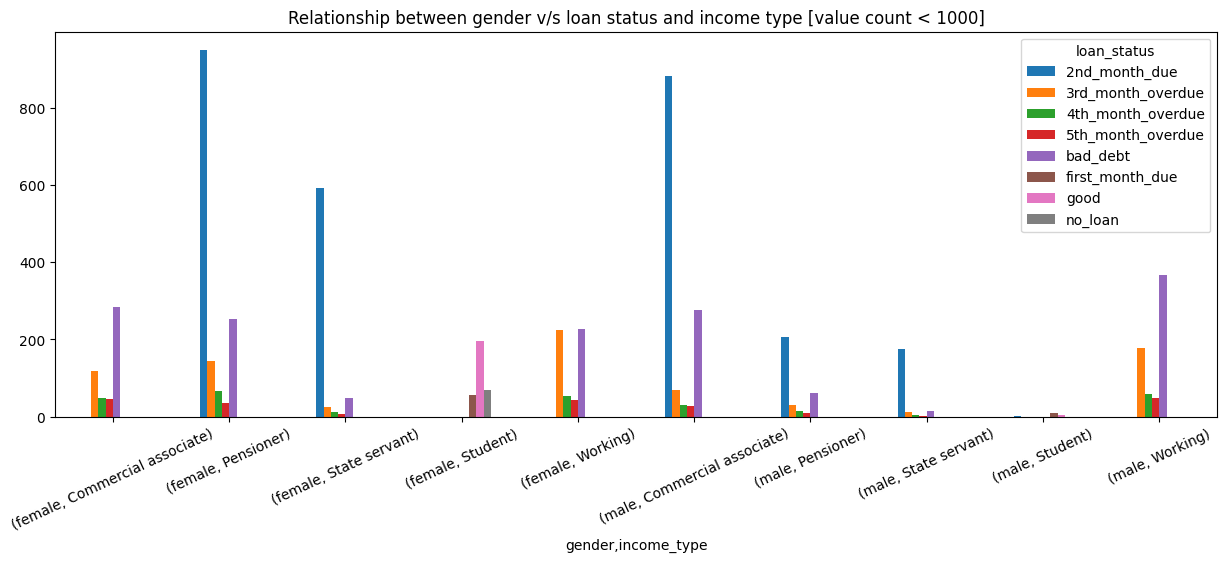

In [ ]:
# checking the relationship between gender v/s income type & loan status
count = df.groupby('gender')[['income_type', 'loan_status' ]].value_counts()

# plotting the barh plot for [gender v/s income type & loan status] value count less than 1000
count[count<1000].unstack().plot(kind='bar' , figsize=(15, 5) , legend=True )
# defining the tilte
plt.title('Relationship between gender v/s loan status and income type [value count < 1000]')
# rotating the x-axis labels
plt.xticks(rotation=25)
plt.show()


### *Area Plot of the relationship between gender v/s income type & loan status with value counts less than 1000*

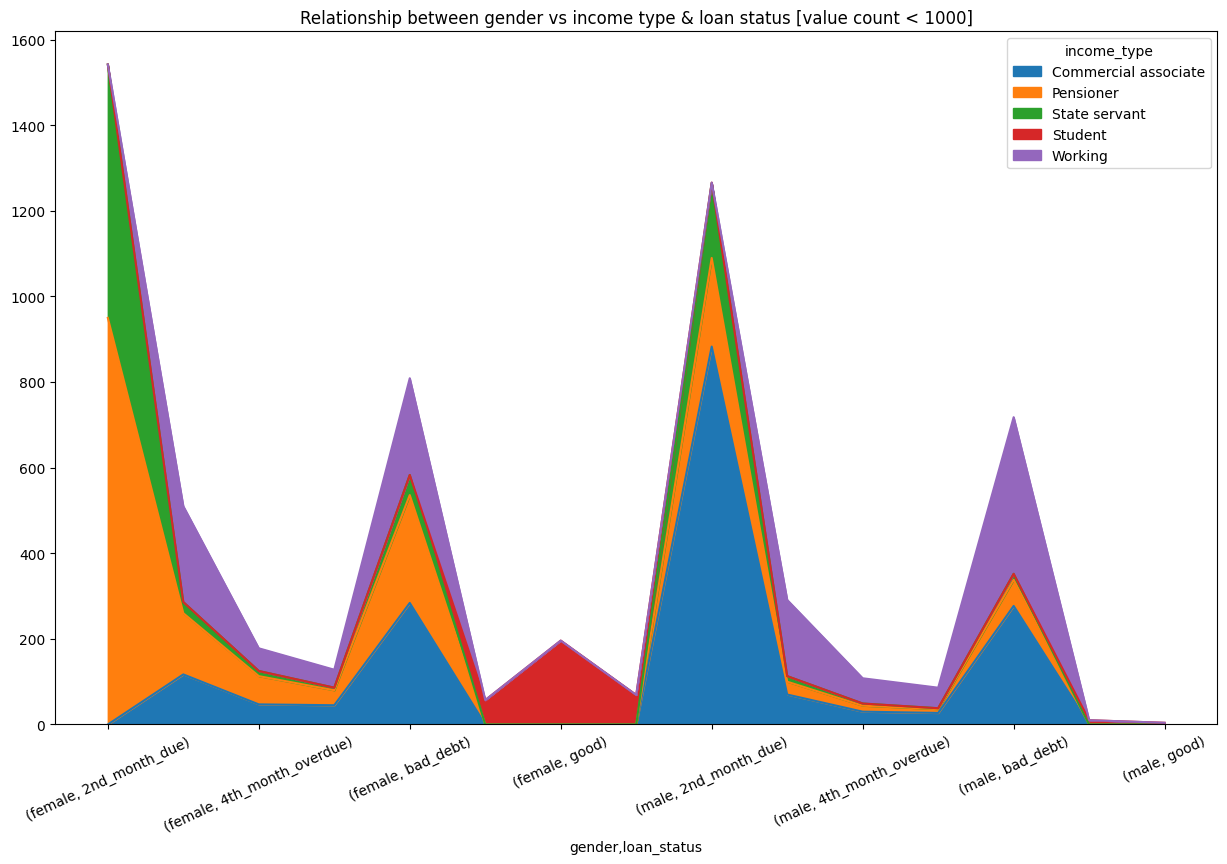

In [ ]:
# checking the relationship between gender vs income type & loan status
count = df.groupby('gender')[['loan_status','income_type']].value_counts()
# plotting the area plot for [gender vs income type & loan status] value count less than 1000
count[count<1000].unstack().plot(kind='area' , figsize=(15, 9))
# defining the tilte
plt.title('Relationship between gender vs income type & loan status [value count < 1000]')
# rotating the x-axis labels
plt.xticks(rotation=25)
plt.show()

---
### **Observation:**
- When we see `loan_status` trends in terms of `income_type` and `gender` we can see that the male with `student inocme_type` has `no_loan for that month`.
- Also, In `good & first month due loan_status` the number male students is very low and compared to females.
- `State servants income type` in both male and female gender have very less numbers in billing overdue of `loan_status`
- Both males and females students has 1 and 0 numbers respectively in `2nd_month_due` of `loan_status`
----

### **Getting insights from `education` and `gender`**

### *checking the value count of `education`*

In [ ]:
# checking the value count of education
df.education.value_counts()

,count
education,
Secondary / secondary special,524261
Higher education,213633
Incomplete higher,30329
Lower secondary,8655
Academic degree,837


### *value count of `education` vs `gender`*

In [ ]:
# checking the relationship between gender and education
df.groupby('gender')[['education']].value_counts()

gender  education                    
female  Secondary / secondary special    349975
        Higher education                 144457
        Incomplete higher                 18638
        Lower secondary                    5177
        Academic degree                     604
male    Secondary / secondary special    174286
        Higher education                  69176
        Incomplete higher                 11691
        Lower secondary                    3478
        Academic degree                     233
Name: count, dtype: int64

### *plotting the value count of `education` vs `gender`*

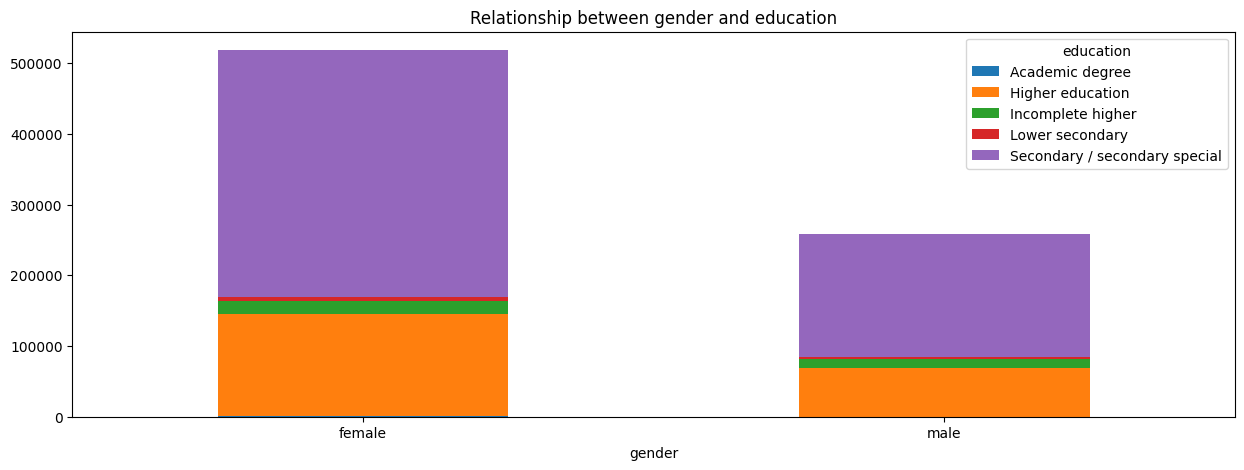

In [ ]:
# plotting the countplot for education vs gender
df.groupby('gender')[['education']].value_counts().unstack().plot(kind='bar', figsize=(15, 5) , stacked=True)

# rotating the x-axis labels
plt.xticks(rotation=360)

# defining the title
plt.title('Relationship between gender and education')
plt.show()

----

### **Observation:**
- As our dataset has larget number of people with `secondary` education.
- Therefore, the number of male and female with `secondary` education is high.
- Moreover, the number of `Lower_secondary & Academic degree` is very less in both male and female
- The proportion of `Lower_secondary` eduaction is similar for both genders
---

### **Getting insights from `education` and `loan_status`**

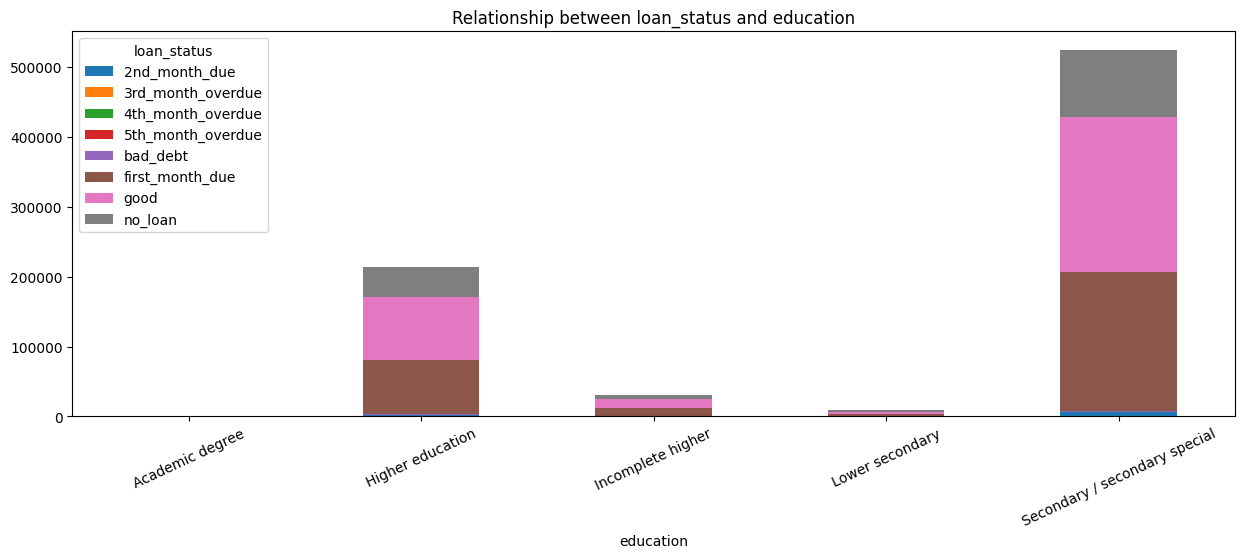

In [ ]:
# checking the relationship between loan_status and education using groupby function
df.groupby('education')[['loan_status']].value_counts().unstack().plot(kind='bar', figsize=(15, 5) , stacked= True)
# defining the tilte
plt.title('Relationship between loan_status and education')
# rotating the x-axis labels
plt.xticks(rotation=25)
plt.show()

### *plotting the barh plot for education vs loan_status [values < 500]*

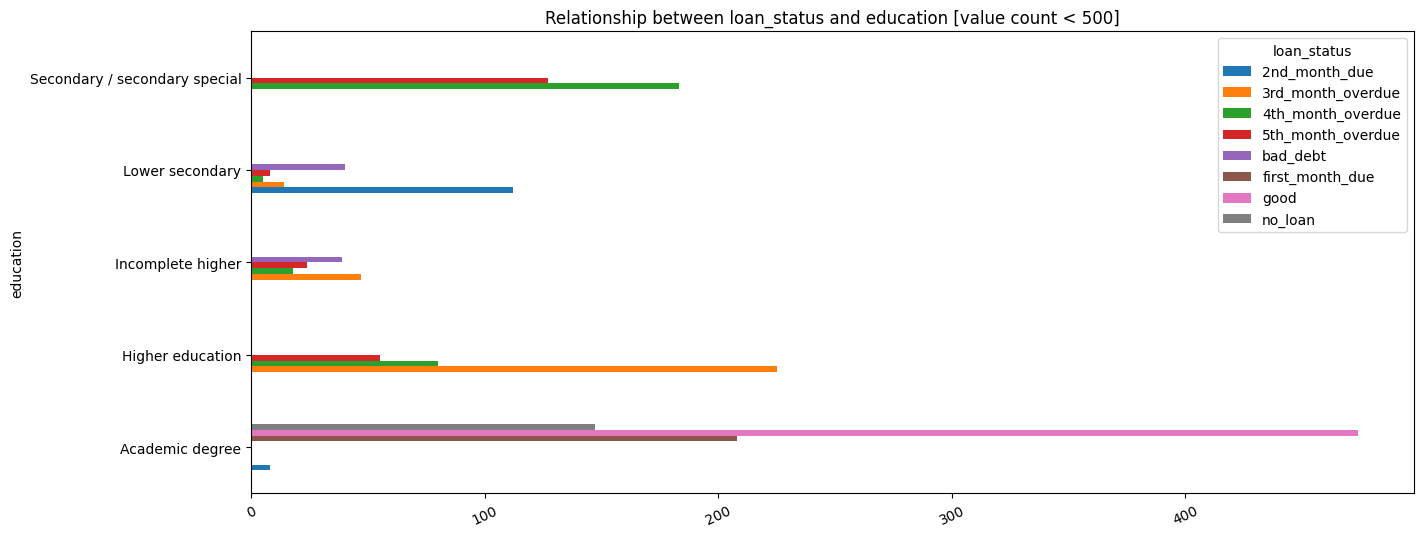

In [ ]:
# checking the relationship between loan_status and education
count = df.groupby('education')[['loan_status']].value_counts()

# plotting the barh plot for education vs loan_status which have values less than 500
count[count<=500].unstack().plot(kind='barh' , figsize=(15, 6))
# defining the tilte
plt.title('Relationship between loan_status and education [value count < 500]')
# rotating the x-axis labels
plt.xticks(rotation=25)
plt.show()

-----

### **Observation:**

- As our dataset has larget number of people with `secondary` education and they have largest numbers who have paid off their loan
- A similar trend can be seen in the `Academic degree` education
- The mostly people who have bad debt are from `Lower_secondary & Incomplete higher` education
---

### **Getting insights from `housing_type` and `loan_status`**

### *unique enteries & value count from `housing_type`*

In [ ]:
# checking the unique enteries from `housing_type` column

df['housing_type'].unique()

array(['Rented apartment', 'House / apartment', 'Municipal apartment',
       'With parents', 'Co-op apartment', 'Office apartment'],
      dtype=object)

In [ ]:
# checking value counts of `housing_type` column
df['housing_type'].value_counts()

,count
housing_type,
House / apartment,697151
With parents,35735
Municipal apartment,24640
Rented apartment,10898
Office apartment,5636
Co-op apartment,3655


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

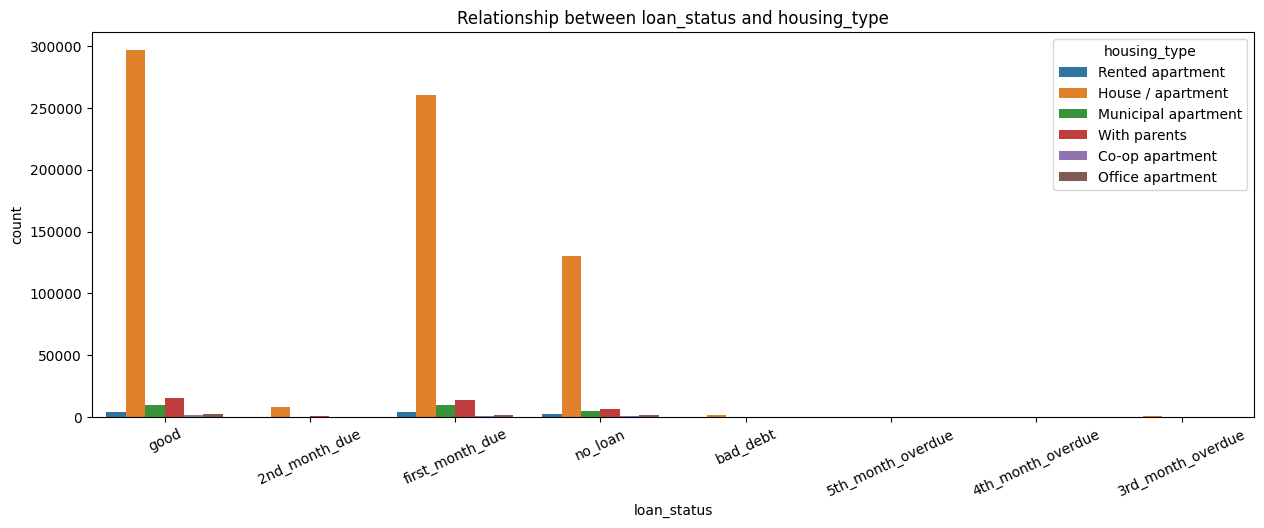

In [ ]:
# checking the relationship between loan_status and housing_type

# defining the figure size
plt.figure(figsize=(15, 5))

# plotting the countplot
sns.countplot(data=df, x=df['loan_status'], hue=df['housing_type'])

plt.xticks(rotation=25)
plt.title('Relationship between loan_status and housing_type')

plt.show()


### *filtering the value counts `housing & loan_status==bad_debt`*

In [ ]:
# checking the relationship between loan_status and housing_type

# Group by 'housing_type' and 'loan_status' to get their counts
count = df.groupby(['housing_type', 'loan_status']).size()

# Get value counts where loan_status is 'bad_devit'
bad_loan= count[count.index.get_level_values('loan_status') == 'bad_debt']
bad_loan


,,0
housing_type,loan_status,
Co-op apartment,bad_debt,16
House / apartment,bad_debt,1368
Municipal apartment,bad_debt,54
Office apartment,bad_debt,14
Rented apartment,bad_debt,29
With parents,bad_debt,46


### *plotting the value count < 1000 from `housing_type & loan_status`*

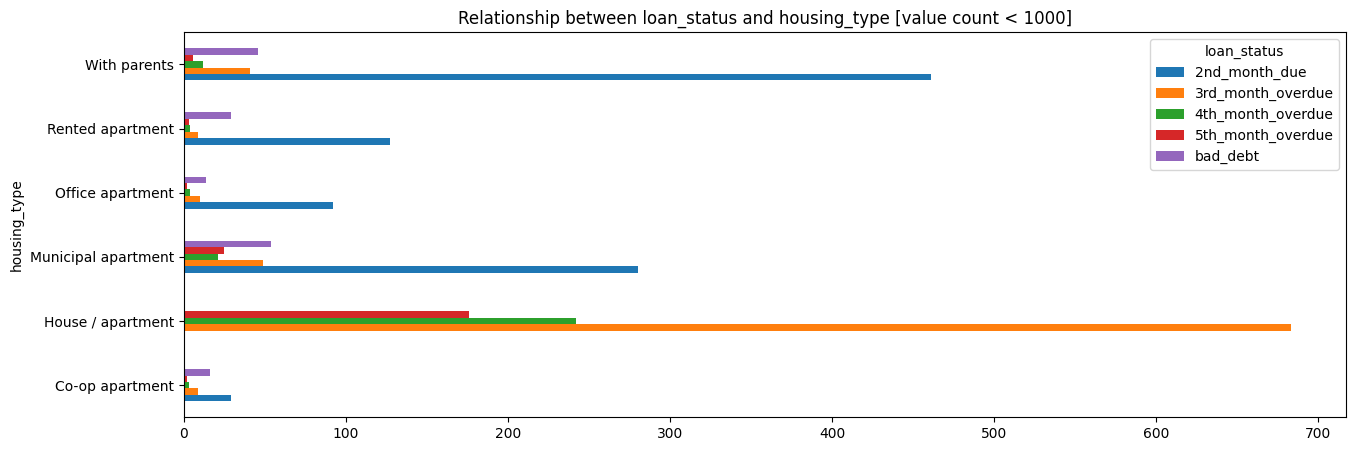

In [ ]:
count = df.groupby(['housing_type', 'loan_status']).size()
count[count<1000].unstack().plot(kind='barh' , figsize=(15, 5) , legend=True )

plt.title('Relationship between loan_status and housing_type [value count < 1000]')

plt.show()

---

### **Observation:**

- Mostly people who have their own house have `good , first month due & no_loan` loan_status which is a positive trend.
- People who live `with parents` have largest share in `2nd_month_due` loan_status. This trend is followed by `Municipal apartment , Rented apartment` and `With office apartment` respectively
- The people with lowest number of `bad_debt` loan_status are from `office apartment & co apartment` housing type
---

### **Getting insights from `family_members` and `loan_status`**

In [ ]:
df.columns # checking the column names

Index(['ID', 'gender', 'own_car', 'own_property', 'children', 'income',
       'income_type', 'education', 'family_status', 'housing_type',
       'age_in_days', 'employment_in_days', 'mobile', 'work_phone', 'phone',
       'email', 'family_members', 'months_balance', 'status', 'loan_status'],
      dtype='object')

In [ ]:
# checking value counts of `family_members`
df.family_members.value_counts()

,count
family_members,
2.0,423723
1.0,141477
3.0,134894
4.0,66990
5.0,8999
6.0,1196
7.0,273
15.0,111
9.0,46


In [ ]:
# checking the relationship between loan_status and family_members
df.groupby('family_members')[['loan_status']].value_counts().unstack()

loan_status,2nd_month_due,3rd_month_overdue,4th_month_overdue,5th_month_overdue,bad_debt,first_month_due,good,no_loan
family_members,,,,,,,,
1.0,1651.0,179.0,71.0,52.0,239.0,53411.0,59894.0,25980.0
2.0,4571.0,414.0,161.0,108.0,808.0,157392.0,181131.0,79138.0
3.0,1528.0,132.0,34.0,34.0,381.0,50885.0,54889.0,27011.0
4.0,858.0,54.0,15.0,18.0,92.0,25110.0,29037.0,11806.0
5.0,108.0,21.0,4.0,1.0,5.0,3234.0,4068.0,1558.0
6.0,16.0,1.0,1.0,1.0,2.0,463.0,442.0,270.0
7.0,NaN,NaN,NaN,NaN,NaN,57.0,53.0,163.0
9.0,10.0,NaN,NaN,NaN,NaN,14.0,22.0,NaN
15.0,5.0,NaN,NaN,NaN,NaN,82.0,NaN,24.0


----

### **Observation:**

- Most of the clients have `2` family member
- The `loan_status` of the atm users is `good , first month due & no_loan` who have `1 ,2 or 3 family member` which is a positive trend
- Wheeras, the number for `loan status = 2nd month due` is comparatively high for `2 family members`
---

### **Checking the relationship between `childern` count &   `loan_status`**

In [ ]:
df.select_dtypes(exclude='object').columns # checking the column names with numeric datatype

Index(['ID', 'children', 'income', 'age_in_days', 'employment_in_days',
       'mobile', 'work_phone', 'phone', 'email', 'family_members',
       'months_balance'],
      dtype='object')

In [ ]:
# checking value counts of `children`
df.children.value_counts()

,count
children,
0,540639
1,155638
2,70399
3,9328
4,1224
5,324
14,111
7,46
19,6


In [ ]:
# checking the relationship between loan_status and children count

df.groupby('children')[['loan_status']].value_counts().unstack()

loan_status,2nd_month_due,3rd_month_overdue,4th_month_overdue,5th_month_overdue,bad_debt,first_month_due,good,no_loan
children,,,,,,,,
0,5908.0,559.0,213.0,146.0,994.0,201794.0,230268.0,100757.0
1,1801.0,156.0,51.0,46.0,434.0,58550.0,64120.0,30480.0
2,888.0,64.0,17.0,20.0,92.0,26171.0,30485.0,12662.0
3,119.0,21.0,4.0,1.0,5.0,3468.0,4143.0,1567.0
4,16.0,1.0,1.0,1.0,2.0,490.0,416.0,297.0
5,NaN,NaN,NaN,NaN,NaN,79.0,82.0,163.0
7,10.0,NaN,NaN,NaN,NaN,14.0,22.0,NaN
14,5.0,NaN,NaN,NaN,NaN,82.0,NaN,24.0
19,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN


### **Getting insights from `employment_in_days`**

### *count of persons who are `unemployed`*

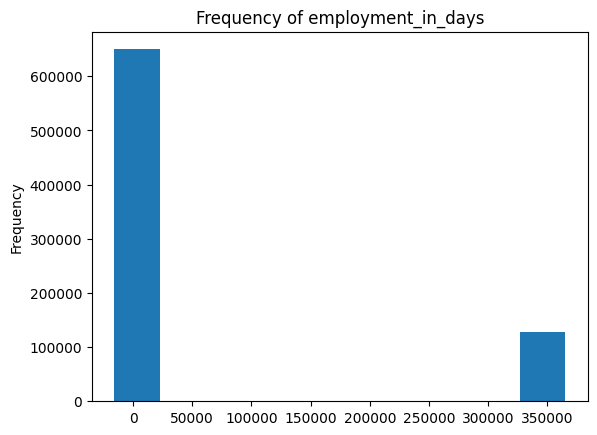

In [ ]:
# plotting histogram of employment_in_days
df['employment_in_days'].plot(kind = 'hist')
# defining the title
plt.title('Frequency of employment_in_days')
plt.show()


In [ ]:
# Filter DataFrame where employment_in_days > 0 to show unemployment count
df[df['employment_in_days'] > 0].value_counts().sum()

127972

---

### **Observations:**

- The value in `employment in days` which are greater than `0` shows the status of the person is `unemployed`
- We have `127972` persone who are `unemployed`

---

### **Checking the relationship between `employment_in_days > 0 (unemployment)` & `loan_status`**

In [ ]:
# Filter DataFrame where employment_in_days is greater than 0
filtered_df = df[df['employment_in_days'] > 0]

# Group by loan_status and calculate value counts
filtered_df.groupby('loan_status').size()



,0
loan_status,
2nd_month_due,1128
3rd_month_overdue,149
4th_month_overdue,73
5th_month_overdue,37
bad_debt,266
first_month_due,47620
good,55172
no_loan,23527


---

### **Observations:**
- The `loan_status` of the most of the `unemployed` persons is `good , first month due & no_loan` which is a positive trend.
- Whereas, the `loan_status` of the `bad_debt` for unemployed persons is very low.
---

# **Data Preprocessing**

In [ ]:
df.columns # printing exact column names

Index(['ID', 'gender', 'own_car', 'own_property', 'children', 'income',
       'income_type', 'education', 'family_status', 'housing_type',
       'age_in_days', 'employment_in_days', 'mobile', 'work_phone', 'phone',
       'email', 'family_members', 'months_balance', 'status', 'loan_status'],
      dtype='object')

### *plotting the scatter plot of numeric columns*

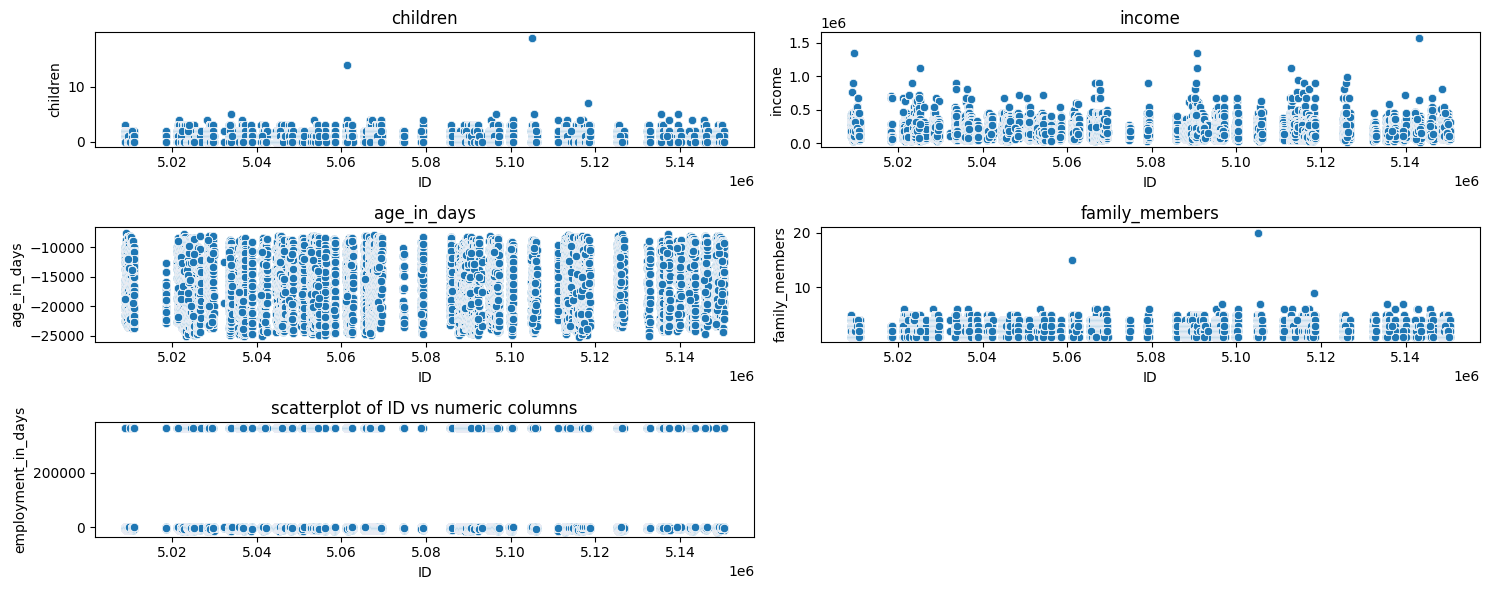

In [ ]:
# checking the relationship between loan_status and income
col = ['children', 'income', 'age_in_days',  'family_members' , 'employment_in_days']

# defining the figure size
plt.figure(figsize=(15, 6))

# plotting the countplot using for loop
for i in range(len(col)):
    plt.subplot(3, 2, i+1)
    plt.title(col[i])  # Use the column name as the title
    sns.scatterplot(data=df, y=col[i], x='ID')
plt.title('scatterplot of ID vs numeric columns')
plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

In [ ]:
df.columns

Index(['ID', 'gender', 'own_car', 'own_property', 'children', 'income',
       'income_type', 'education', 'family_status', 'housing_type',
       'age_in_days', 'employment_in_days', 'mobile', 'work_phone', 'phone',
       'email', 'family_members', 'months_balance', 'status', 'loan_status'],
      dtype='object')

### *plotting the boxplot of numeric columns*

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


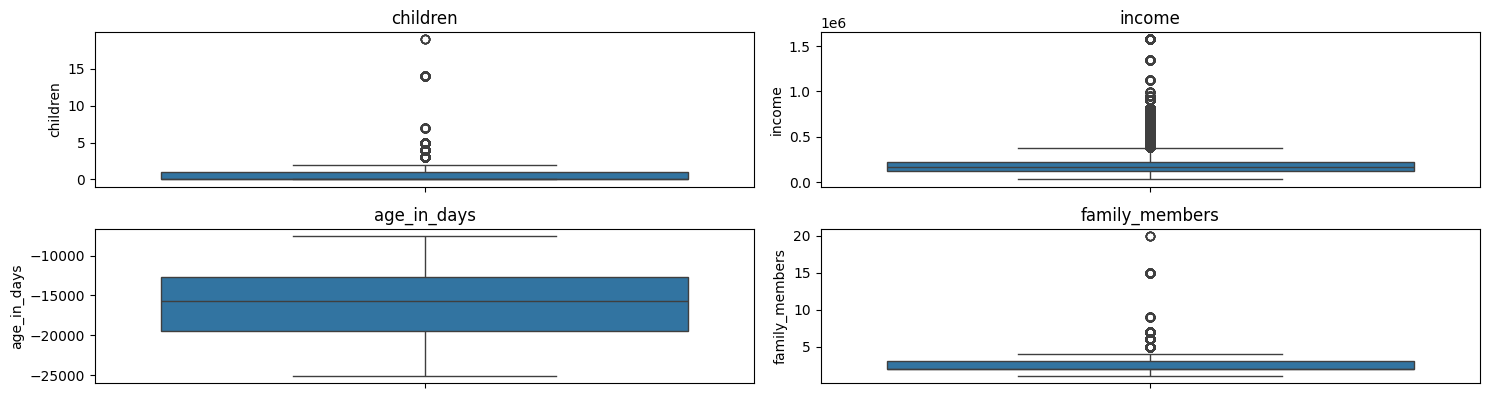

In [ ]:
# checking the relationship between loan_status and income

# filtering the list of specific columns
col = ['children', 'income', 'age_in_days',  'family_members' ]

# defining the figure size
plt.figure(figsize=(15, 6))

# plotting the countplot using for loop
for i in range(len(col)):
    plt.subplot(3, 2, i+1)
    plt.title(col[i])  # Use the column name as the title
    sns.boxplot(data=df, y=col[i])

plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

---
### **Observations**
- As we can see that the outliers are present in three columns:
  - income
  - children
  - family_members
- Both scatter plot and box plot are showing outliers in the above mention columns
  
----

### *Removing outliers from `['children', 'income' , 'family_members']`*

In [ ]:
# removing outliers

# filtering the list of specific columns
col = ['children', 'income' , 'family_members']

# for loop to remove outliers
for i in range(len(col)):
    # calculating the first and third quartile
    q1 = df[col[i]].quantile(0.25)
    q3 = df[col[i]].quantile(0.75)
    # calculating the interquartile range
    iqr = q3 - q1
    # calculating the lower and upper bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # replacing the outliers with the median
    df[col[i]] = np.where((df[col[i]] >= upper_bound) | (df[col[i]] <= lower_bound), df[col[i]].median() , df[col[i]])

### *again plotting boxplot to confirm outcomes*

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


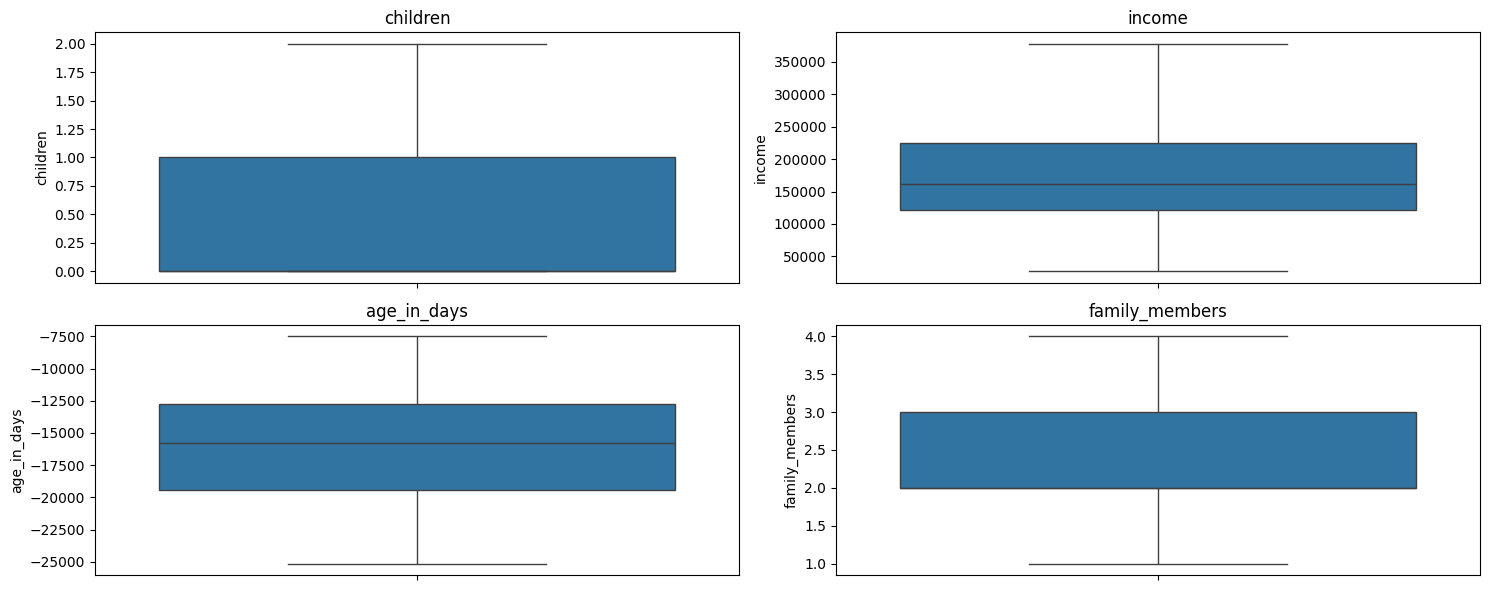

In [ ]:
col = ['children', 'income', 'age_in_days',  'family_members']

plt.figure(figsize=(15, 6))

for i in range(len(col)):
    plt.subplot(2, 2, i+1)
    plt.title(col[i])  # Use the column name as the title
    sns.boxplot(data=df, y=col[i])

plt.tight_layout()  # Adjust the layout to prevent overlapping
plt.show()

In [ ]:
df.select_dtypes(exclude='object').columns

Index(['ID', 'children', 'income', 'age_in_days', 'employment_in_days',
       'mobile', 'work_phone', 'phone', 'email', 'family_members',
       'months_balance'],
      dtype='object')

### **Standardization**

In [ ]:
# filtering the list of specific columns
col = ['children', 'income', 'age_in_days',  'family_members']

# calling the standard scaler
sc = StandardScaler()
# for loop to scale the specific columns
for i in col:
    df[i] = sc.fit_transform(df[[i]])

----

# **Suitability of Model(Random Forest Classifier)**

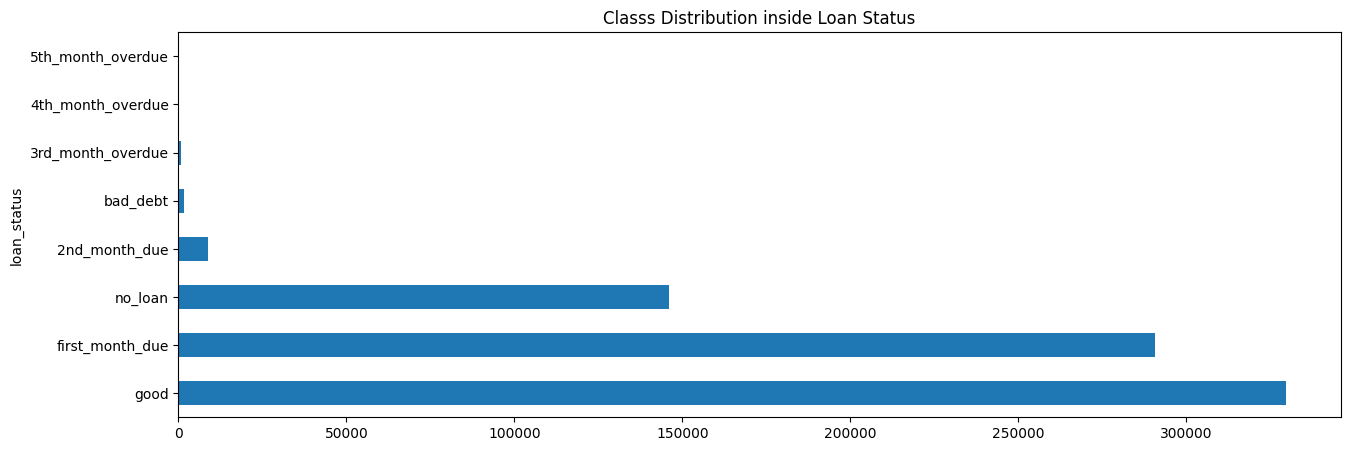

In [ ]:
# checking the distribution of loan_status
df.loan_status.value_counts().plot(kind='barh', figsize=(15, 5))
# defining the title
plt.title('Classs Distribution inside Loan Status')
plt.show()

---

### **Observation:**

- The `loan_status` is our `target variable`.
- If we see the class distribution, of our target variable `loan_status`, we can see that our target variable is highly imbalanced.
- Which means that we cannot use `logistic regression` on our data.
- That is why we need to use `Random Forest Classifier` for our model.
---

In [ ]:
df.head()

,ID,gender,own_car,own_property,children,income,income_type,education,family_status,housing_type,age_in_days,employment_in_days,mobile,work_phone,phone,email,family_members,months_balance,status,loan_status
0,5008804,male,yes,yes,-0.590317,-0.168401,Working,Higher education,Civil marriage,Rented apartment,1.00381,-4542,1,1,0,0,-0.199667,0,C,good
1,5008804,male,yes,yes,-0.590317,-0.168401,Working,Higher education,Civil marriage,Rented apartment,1.00381,-4542,1,1,0,0,-0.199667,-1,C,good
2,5008804,male,yes,yes,-0.590317,-0.168401,Working,Higher education,Civil marriage,Rented apartment,1.00381,-4542,1,1,0,0,-0.199667,-2,C,good
3,5008804,male,yes,yes,-0.590317,-0.168401,Working,Higher education,Civil marriage,Rented apartment,1.00381,-4542,1,1,0,0,-0.199667,-3,C,good
4,5008804,male,yes,yes,-0.590317,-0.168401,Working,Higher education,Civil marriage,Rented apartment,1.00381,-4542,1,1,0,0,-0.199667,-4,C,good


# **Label Encoding**


In [ ]:
df.columns # printing exact column names


Index(['ID', 'gender', 'own_car', 'own_property', 'children', 'income',
       'income_type', 'education', 'family_status', 'housing_type',
       'age_in_days', 'employment_in_days', 'mobile', 'work_phone', 'phone',
       'email', 'family_members', 'months_balance', 'status', 'loan_status'],
      dtype='object')

In [ ]:
# filtering the list of specific columns which we need to encode
col = ['gender', 'own_car', 'own_property', 'income_type','education', 'family_status', 'housing_type', 'status']

# calling the label encoder
le = LabelEncoder()

# for loop to encode the specific columns
for i in col:
    df[i] =le.fit_transform(df[i] )


In [ ]:
df.head() # previewing the dataset

,ID,gender,own_car,own_property,children,income,income_type,education,family_status,housing_type,age_in_days,employment_in_days,mobile,work_phone,phone,email,family_members,months_balance,status,loan_status
0,5008804,1,1,1,-0.590317,-0.168401,4,1,0,4,1.00381,-4542,1,1,0,0,-0.199667,0,6,good
1,5008804,1,1,1,-0.590317,-0.168401,4,1,0,4,1.00381,-4542,1,1,0,0,-0.199667,-1,6,good
2,5008804,1,1,1,-0.590317,-0.168401,4,1,0,4,1.00381,-4542,1,1,0,0,-0.199667,-2,6,good
3,5008804,1,1,1,-0.590317,-0.168401,4,1,0,4,1.00381,-4542,1,1,0,0,-0.199667,-3,6,good
4,5008804,1,1,1,-0.590317,-0.168401,4,1,0,4,1.00381,-4542,1,1,0,0,-0.199667,-4,6,good


# **Best Features Selection: Random Forest Classifier**

### **Independence of Observations:**
### *Correlation Matrix for Numerical Features*

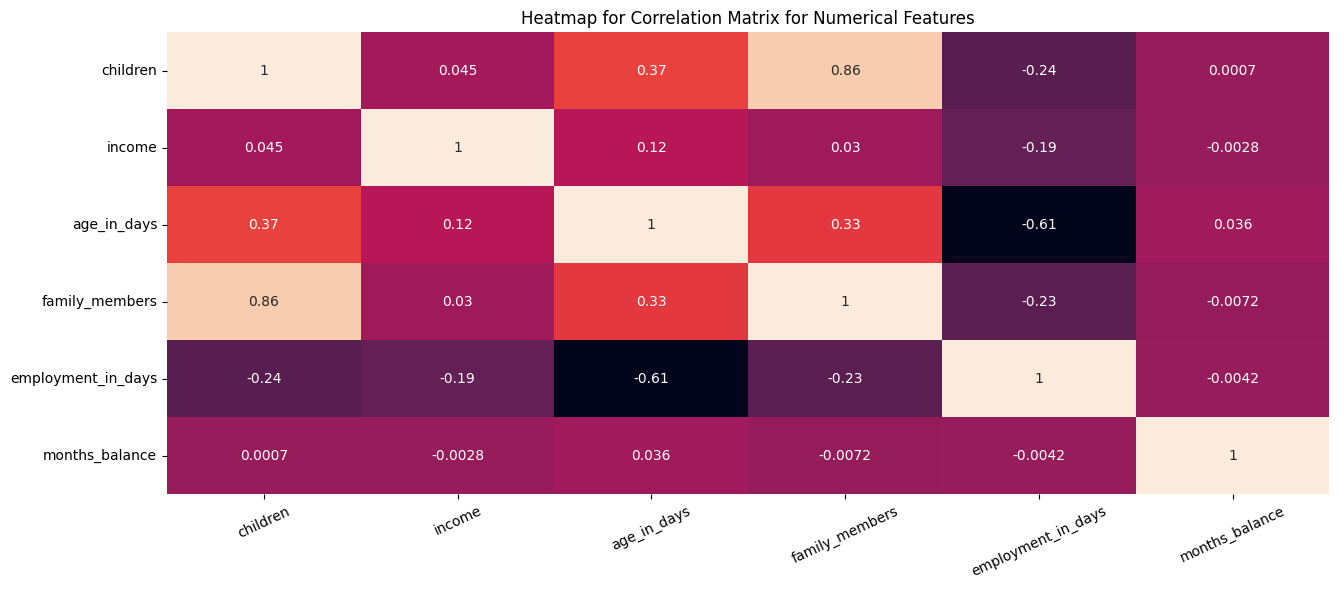

In [ ]:
# correlation matrix

# defining the figure size
plt.figure(figsize=(15, 6))
# plotting the heatmap
sns.heatmap(df[['children', 'income', 'age_in_days',  'family_members', 'employment_in_days', 'months_balance']].corr(), annot=True , cbar=False)
# defining the title and rotation of x-axis labels
plt.xticks(rotation=25)
plt.title('Heatmap for Correlation Matrix for Numerical Features')
plt.show()

----
### **Observation**
- As we can see that `children` and `family_members` are highly correlated with each other
- But there is no strong correlation between other numerical features

- Hence, the condition of `Independence of Observations` is almost satisfied for `Random Forest Classifier`.

---

### **Check for Multicollinearity**

### *Variance Inflation Factor*

In [ ]:

# Drop 'loan_status' and 'status' columns from col
col = df.drop(['loan_status', 'status'], axis=1) # Assume that col is our independent variable

# Compute variance inflation factor

# Create a dataframe to store the VIF
factor  = pd.DataFrame(columns=["VIF", "Features"] )
# For each column, compute the VIF
factor["Features"] = col.columns
factor["VIF"] = [variance_inflation_factor(col.values, i) for i in range(col.shape[1])]

# Display the results
factor

,VIF,Features
0,1.019165,ID
1,1.240486,gender
2,1.218307,own_car
3,1.096036,own_property
4,12.236508,children
5,1.165436,income
6,1.187861,income_type
7,1.090580,education
8,4.476697,family_status
9,1.072517,housing_type


---

### **Observation**

- Multicollinearity occurs when two or more predictor variables in the model are highly correlated.

- Variance Inflation Factor (VIF) is 1.0 for all columns except `children`, `family_status` and `mobile` which are highly correlated with each other.
- Also, the columns `children` and `family_status` are highly correlated with each other.
- Hence, we need to drop `children , family_status & mobile` columns from our independent variable list to get best results from Random Forest Classifier.
---

# **Model Building**

### *Spliting the dataset into Features and Labels*

In [ ]:
X = df.drop(['loan_status' , 'status', 'children' , 'family_members', 'mobile'], axis = 1) # Assume that X is our independent variable

y = df['loan_status'] # Assume that y is our dependent variable

In [ ]:
# checking the column names of independent variable(X)
X.columns

Index(['ID', 'gender', 'own_car', 'own_property', 'income', 'income_type',
       'education', 'family_status', 'housing_type', 'age_in_days',
       'employment_in_days', 'work_phone', 'phone', 'email', 'months_balance'],
      dtype='object')

In [ ]:
X.head() # previewing the independent variable X

,ID,gender,own_car,own_property,income,income_type,education,family_status,housing_type,age_in_days,employment_in_days,work_phone,phone,email,months_balance
0,5008804,1,1,1,-0.168401,4,1,0,4,1.00381,-4542,1,0,0,0
1,5008804,1,1,1,-0.168401,4,1,0,4,1.00381,-4542,1,0,0,-1
2,5008804,1,1,1,-0.168401,4,1,0,4,1.00381,-4542,1,0,0,-2
3,5008804,1,1,1,-0.168401,4,1,0,4,1.00381,-4542,1,0,0,-3
4,5008804,1,1,1,-0.168401,4,1,0,4,1.00381,-4542,1,0,0,-4


In [ ]:
print(f'The shpape of X ={X.shape} \n') # checking the shape of X

print(f'The shape of y ={y.shape}') # checking the shape of y

The shpape of X =(777715, 15) 

The shape of y =(777715,)


### *Train Test Split*

In [ ]:
# splitting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

---

### **Observation:**
- We have splitted the dataset into 80% train and 20% test
- We have used `Random Forest Classifier` as our model
- 80% of our dataset is used for training
- 20% of our dataset is used for testing
---

### *Calling the model*

In [ ]:
# instantiating the model
model = RandomForestClassifier()

### *Fitting the model*

In [ ]:
# fitting the model
model.fit(X_train, y_train )

RandomForestClassifier()

### *Predicting the model*

In [ ]:
# making predictions on the test set
y_pred = model.predict(X_test)

### *Actual vs Predicted*

In [ ]:
# creating a dataframe to compare the actual and predicted values
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head(10)

,Actual,Predicted
489996,first_month_due,first_month_due
293437,first_month_due,first_month_due
544675,first_month_due,first_month_due
688170,good,good
582519,no_loan,first_month_due
248623,good,good
476807,first_month_due,first_month_due
693691,good,good
89611,good,good
756662,good,good


### *Model Evaluation*

In [ ]:
(f'Accuracy Score : {accuracy_score(y_test, y_pred)*100:.2f} %')

'Accuracy Score : 88.14 %'

In [ ]:
print(f"Precision Score : {precision_score(y_test, y_pred , average = 'micro'):.2f}")

Precision Score : 0.88


In [ ]:
print(f"F1-Score : {f1_score(y_test, y_pred , average='micro')}")

F1-Score : 0.8814218576213652


In [ ]:
# classification report
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

    2nd_month_due       0.33      0.26      0.29      1743
3rd_month_overdue       0.17      0.15      0.16       150
4th_month_overdue       0.05      0.04      0.04        52
5th_month_overdue       0.03      0.03      0.03        33
         bad_debt       0.92      0.86      0.89       307
  first_month_due       0.84      0.87      0.86     58003
             good       0.95      0.95      0.95     66226
          no_loan       0.83      0.78      0.80     29029

         accuracy                           0.88    155543
        macro avg       0.52      0.49      0.50    155543
     weighted avg       0.88      0.88      0.88    155543



----
### **Interpretation**

#### **Accuracy Score**
- Accuracy score is basically the percentage of correct predictions made by the model out of all the predictions
  -  (i.e. the number of correct predictions divided by the total number of predictions)
  
The value of accuracy score ranges from 0 to 1 (100%).

  **The accuracy score is of our model is `88.11%` which is really good**



### **Precision Score**
- Precision score is basically the percentage of correct positive predictions made by the model
  - Formula: Precision = TP / (TP + FP)
  - ( i.e. the number of correct positive predictions divided by the total number of positive predictions)
- The value of precision score ranges from 0 to 1.
- We calculated the precision score of our model using the parameter `average = 'micro'` which calculates the precision score globally by considering the total number of true positives, false positives, and false negatives across all classes. It treats all instances (samples) equally, regardless of their class labels.
  
  **The precision score is of our model is `0.88` which indicates that the number of False positives is very less.**


### **Recall Score**
- Recall is basically the percentage of correct negative predictions made by the model
  - Formula: Recall = TP / (TP + FN)
  - (i.e. the number of correct negative predictions divided by the total number of negative predictions)
- The value of recall score ranges from 0 to 1.
  
  **The Recall score is of our model is `0.8811` which indicates that the number of False negatives is very less.**


### **F1 Score**

- F1 score is basically the harmonic mean of precision and recall
  - Formula: F1 = 2 * (precision * recall) / (precision + recall)
- It is usefull when we have imbalanced classes in our dataset and it gives the best results by including precision and recall.
----
